In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [198]:
train = pd.read_csv('data/sibur_train.csv')
test = pd.read_csv('data/sibur_test.csv')

In [199]:
train

,material_code,company_code,country,region,manager_code,month,vol_tm6,vol_tm5,vol_tm4,vol_tm3,vol_tm2,vol_tm1,last_year_avg,last_year_min,last_year_max,target
0,109.304995,109.304995,109.304995,109.304995,109.304995,1,220.0,220.0,220.0,280.0,280.0,280.0,260.000000,220.0,340.0,200.0
1,109.304995,109.304995,109.304995,109.304995,109.304995,1,0.0,0.0,0.0,0.0,0.0,0.0,21.666667,0.0,200.0,0.0
2,54.652497,54.652497,54.652497,109.304995,54.652497,1,0.0,0.0,100.0,220.0,20.0,0.0,40.000000,0.0,220.0,0.0
3,36.434998,36.434998,36.434998,109.304995,36.434998,1,180.0,99.0,60.0,400.0,120.0,20.0,91.583333,0.0,400.0,40.0
4,37.326249,37.326249,109.304995,109.304995,109.304995,1,40.0,20.0,40.0,30.0,0.0,40.0,19.166667,0.0,40.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11287,81.197104,9.108750,96.244657,75.909940,96.644710,12,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
11288,59.495667,72.628814,96.233404,51.984540,39.299434,12,10.0,5.0,5.0,10.0,10.0,0.0,5.250000,0.0,10.0,6.0
11289,58.332717,85.512708,96.222855,51.792937,82.683294,12,121.0,121.0,129.0,117.0,115.0,102.0,83.833333,0.0,129.0,29.0
11290,57.708617,139.402187,96.214998,84.871469,82.504350,12,100.0,120.0,120.0,80.0,120.0,140.0,119.916667,80.0,160.0,100.0


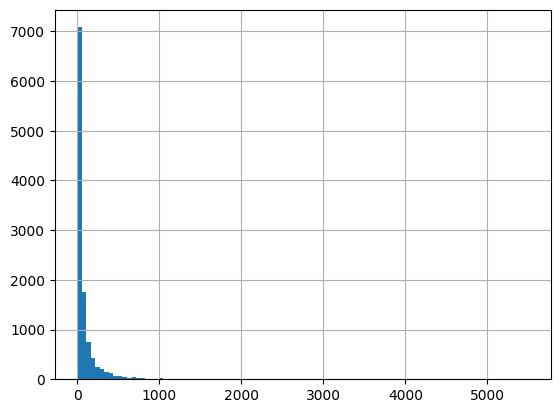

In [200]:
train['target'].hist(bins=100)
plt.show()

1. Cначала построим модель линейной регрессии и предсказания для train и test, проверим результаты с помощью метрики RMSLE

In [201]:
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_log_error

In [202]:
model = LinearRegression()

In [203]:
X_train = train.drop('target', axis=1)
y_train = train['target']

In [204]:
result = model.fit(X_train, y_train)

In [205]:
predicts_train = result.predict(X_train)

In [206]:
predicts_train[predicts_train < 0] = 0

In [207]:
X_test = test.drop('target', axis=1)
y_test = test['target']

In [208]:
predicts_test = result.predict(X_test)

In [209]:
predicts_test[predicts_test < 0] = 0

In [210]:
print('RMSLE for (X, y) train = ', np.sqrt(mean_squared_log_error(y_train.values, predicts_train)))
print('RMSLE for () test = ', np.sqrt(mean_squared_log_error(y_test.values, predicts_test)))

RMSLE for train =  1.8418781544679241
RMSLE for test =  2.064505432857435


2. Прологарифмируем целевую переменную с помощью функции np.log1p и повторим действия

In [211]:
def func(y):
    return np.log1p(y)

def inverse_func(y):
    return np.expm1(y)

In [212]:
model_log = TransformedTargetRegressor(regressor=model, 
                                       func=func, 
                                       inverse_func=inverse_func)

In [213]:
result_log = model_log.fit(X_train, y_train)

In [214]:
predicts_train_log = result_log.predict(X_train)

In [215]:
predicts_train_log[predicts_train_log < 0] = 0

In [216]:
predicts_test_log = result_log.predict(X_test)

In [217]:
predicts_test_log[predicts_test_log < 0] = 0

In [218]:
print('RMSLE for log train = ', np.sqrt(mean_squared_log_error(y_train.values, predicts_train_log)))
print('RMSLE for log test = ', np.sqrt(mean_squared_log_error(y_test.values, predicts_test_log)))

RMSLE for log train =  1.979316537402208
RMSLE for log test =  2.087630611042271


3. Посмотрим на факторные переменные: возможно, их тоже можно преобразовать и улучшить результат?

In [219]:
cols = train.columns

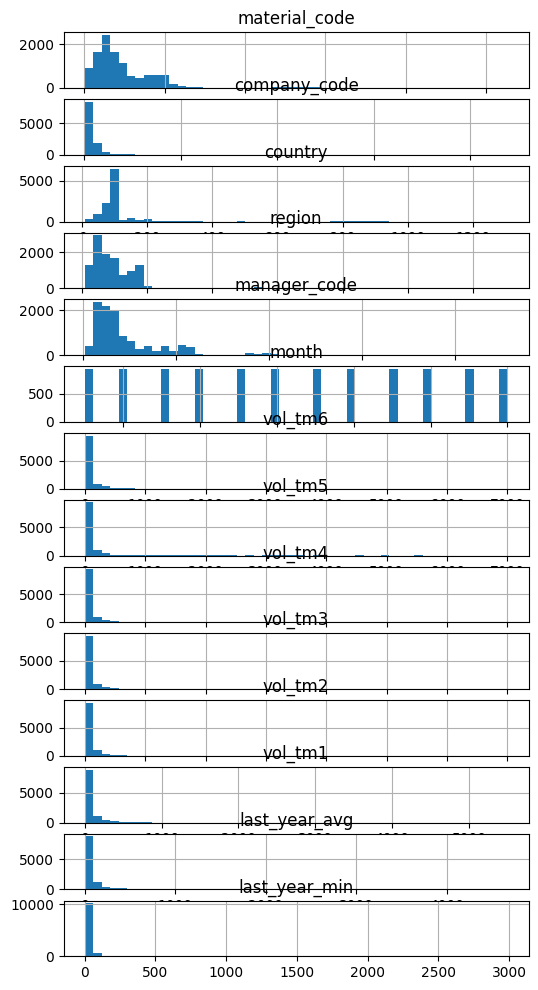

In [220]:
fig, axarr = plt.subplots(14, 1, figsize=(12, 6))
for i in range(14):
    train[cols[i]].hist(figsize=(6, 12), bins=50, ax=axarr[i])
for i, axarr in enumerate(axarr.ravel()):
    axarr.set_title("{}".format(cols[i]))
plt.show()

Видим, что все данные кроме month имеют длинный затухающий хвост, надо их логарифмировать

In [221]:
X_basic = train.loc[:,'material_code':'month']

In [222]:
X_log = np.log1p(train.loc[:,'vol_tm6':'last_year_max'])

In [223]:
X = pd.concat([X_basic, X_log], axis=1)

In [239]:
X

,material_code,company_code,country,region,manager_code,month,vol_tm6,vol_tm5,vol_tm4,vol_tm3,vol_tm2,vol_tm1,last_year_avg,last_year_min,last_year_max
0,109.304995,109.304995,109.304995,109.304995,109.304995,1,5.398163,5.398163,5.398163,5.638355,5.638355,5.638355,5.564520,5.398163,5.831882
1,109.304995,109.304995,109.304995,109.304995,109.304995,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.120895,0.000000,5.303305
2,54.652497,54.652497,54.652497,109.304995,54.652497,1,0.000000,0.000000,4.615121,5.398163,3.044522,0.000000,3.713572,0.000000,5.398163
3,36.434998,36.434998,36.434998,109.304995,36.434998,1,5.198497,4.605170,4.110874,5.993961,4.795791,3.044522,4.528109,0.000000,5.993961
4,37.326249,37.326249,109.304995,109.304995,109.304995,1,3.713572,3.044522,3.713572,3.433987,0.000000,3.713572,3.004031,0.000000,3.713572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11287,81.197104,9.108750,96.244657,75.909940,96.644710,12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11288,59.495667,72.628814,96.233404,51.984540,39.299434,12,2.397895,1.791759,1.791759,2.397895,2.397895,0.000000,1.832581,0.000000,2.397895
11289,58.332717,85.512708,96.222855,51.792937,82.683294,12,4.804021,4.804021,4.867534,4.770685,4.753590,4.634729,4.440689,0.000000,4.867534
11290,57.708617,139.402187,96.214998,84.871469,82.504350,12,4.615121,4.795791,4.795791,4.394449,4.795791,4.948760,4.795102,4.394449,5.081404


In [235]:
result_X_log = model.fit(X, np.log1p(y_train))

In [236]:
predicts_train_X_log = result_X_log.predict(X)

In [237]:
predicts_train_X_log[predicts_train_X_log < 0] = 0

In [241]:
X_basic_test = test.loc[:,'material_code':'month']

In [242]:
X_log_test = np.log1p(test.loc[:,'vol_tm6':'last_year_max'])

In [243]:
X_test = pd.concat([X_basic_test, X_log_test], axis=1)

In [244]:
predicts_test_X_log = result.predict(X_test)

In [245]:
predicts_test_X_log[predicts_test_X_log < 0] = 0

In [247]:
print('RMSLE for (logX, y) train = ', np.sqrt(mean_squared_log_error(y_train.values, np.expm1(predicts_train_X_log))))
print('RMSLE for (logX, y) test = ', np.sqrt(mean_squared_log_error(y_test.values, np.expm1(predicts_test_X_log))))

RMSLE for (logX, y) train =  1.5296335422585057
RMSLE for (logX, y) test =  1.742170381890992
